## Imports and function definitions 

In [1]:
import cv2 as cv
import itertools
import math
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
from scipy import stats
from scipy import interpolate 
from scipy import optimize
from scipy.ndimage import zoom, rotate
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import sys
import warnings

warnings.filterwarnings('ignore')
random_seed = 53

In [2]:
slices_fig_size = (40,8)
brain_map_shape = (40, 57, 66)

In [3]:
parent_dir = '../../data/processed_anesth_registered_response_4th_offset/'
parent_dir = '../../data/processed_anesth_registered_response_4th_offset/'
# parent_dir = '../data/processed_data/response_onset_4/all/'
data_dir =  parent_dir + '/images'
response_dir =  parent_dir + '/responses'

In [4]:
def get_reponse_from_file_name(file_name):
    response_file_path = os.path.join(response_dir, str(file_name))
    response_array = np.load(response_file_path)
    return response_array

def get_responses_of_groups(files, active_indices=None):
    responses = []
    for file_name in files:
        response_array = get_reponse_from_file_name(file_name)
        if active_indices is not None:
            response_array = response_array[active_indices]
        responses.append(response_array.flatten())
    return np.array(responses)

def get_responses_of_groups_from_pais(file_pairs, active_indices=None):
    responses_1 = []
    responses_2 = []
    for file_name_pair in file_pairs:
        response_array_1 = get_reponse_from_file_name(file_name_pair[0])
        response_array_2 = get_reponse_from_file_name(file_name_pair[1])
        if active_indices is not None:
            response_array_1 = response_array_1[active_indices].flatten() 
            response_array_2 = response_array_2[active_indices].flatten() 
        else:
            response_array_1 = response_array_1.flatten() 
            response_array_2 = response_array_2.flatten() 
        responses_1.append(response_array_1)
        responses_2.append(response_array_2)
    return np.array(responses_1), np.array(responses_2)

In [5]:
def get_stacked_slices(data, apply_filter=False, kernel=None, first_slice=13, last_skip_slice=11, divide_by=3):
    I_proc = np.zeros((40,3762))
    for j in range(data.shape[2]):
        I_proc[:, j*data.shape[1]:(j+1)*data.shape[1]] = data[:,:,j]
        if apply_filter:
            I_proc[:, j*data.shape[1]:(j+1)*data.shape[1]] = cv.filter2D(data[:,:,j],-1,kernel)

    I_proc = I_proc[:, (first_slice*57)-1:(-last_skip_slice*57)]
    crop_len = int(I_proc.shape[1]/divide_by)
    arrays = [I_proc[:,i*crop_len:(i+1)*crop_len] for i in range(divide_by)]
    I_proc=np.vstack(arrays)
    return I_proc


In [6]:
def get_correlations(actual_values, predictions):
    # Calculate correlation for each voxel
    correlations = []
    non_nan_correlations = []
    for i in range(predictions.shape[1]):
        correlation_matrix = np.corrcoef(actual_values[:,i], predictions[:,i])
        correlation = np.diag(correlation_matrix, 1)
        if np.isnan(correlation).any():
            correlations.append(0.00001)
            #correlations.append(correlation)
            #pass
        else:
            correlations.append(correlation)
            non_nan_correlations.append(correlation)

    correlations = np.array(correlations)
    non_nan_correlations = np.array(non_nan_correlations)

    # Calculate average correlation and standard error
    average_correlation = np.mean(non_nan_correlations)
    standard_error = stats.sem(non_nan_correlations)

    # Calculate mean absolute correlations and std error
    abs_average_correlation = np.mean(abs(non_nan_correlations))
    abs_standard_error = stats.sem(abs(non_nan_correlations))

    print(f"Average Correlation: {average_correlation} ± {standard_error}")
    # print(f"Average Absolute Correlation: {abs_average_correlation} ± {abs_standard_error}")
    return correlations, non_nan_correlations

In [7]:
def remove_element(l, indx):
    li = l.copy()
    if indx < len(li):
        del li[indx]
    return li

## Reading input and response data


In [8]:
print("response shape", np.load(parent_dir+'/responses/10.npy').shape)
# # Create a list of file names in your data directory
file_list = os.listdir(response_dir)
resp = np.array([np.load(response_dir + '/' + fname) for fname in file_list])

active_indices = tuple(np.load('./../../data/active_indices/thresholded_offset_4_active_indices_percentile_99.npy'))
meta_data_dir = parent_dir
stratified_maps = pd.read_csv(meta_data_dir + '/metadata/img_ids.csv')
stratified_maps['img_file'] = stratified_maps.stim_id.astype(str)+'.npy'
stratified_maps['shuffle_img_file'] = stratified_maps['img_file'].sample(768).values
# stratified_maps['block_id'] = stratified_maps.stim_id.apply(lambda x: int(int(x)/12))
stratified_maps['block_id'] = stratified_maps.groupby('stim_type').ngroup()
image_dict = stratified_maps[['img_file', 'img_id']].set_index('img_file').to_dict()['img_id']
# image_dict = stratified_maps[['img_file', 'block_id']].rename(
#     columns ={"block_id":"img_id"}).set_index('img_file').to_dict()['img_id']

# stratified_maps = stratified_maps.loc[stratified_maps.stim_type=='Mice']

response shape (40, 57, 66)


In [9]:
stratified_maps

,stimArray,img_id,stim_id,stim_type,img_file,shuffle_img_file,block_id
0,stims/Mouse9.npy,35,0,Mice,0.npy,90.npy,2
1,stims/Mouse7.npy,33,1,Mice,1.npy,81.npy,2
2,stims/Mouse8.npy,34,2,Mice,2.npy,459.npy,2
3,stims/Mouse11.npy,26,3,Mice,3.npy,231.npy,2
4,stims/Mouse6.npy,32,4,Mice,4.npy,580.npy,2
...,...,...,...,...,...,...,...
763,stims/textureScramble_Bird2.npy,16,763,Birds_texture,763.npy,496.npy,1
764,stims/textureScramble_Bird5.npy,19,764,Birds_texture,764.npy,323.npy,1
765,stims/textureScramble_Bird7.npy,21,765,Birds_texture,765.npy,210.npy,1
766,stims/textureScramble_Bird12.npy,15,766,Birds_texture,766.npy,168.npy,1


In [10]:
grouped_img_df = stratified_maps.groupby('img_id', as_index=False).agg(
{
    'img_file':list,
    'stimArray':'count'
}
).rename(
    columns ={"block_id":"img_id"})

shuffle_grouped_img_df = stratified_maps.groupby('img_id', as_index=False).agg(
{
    'shuffle_img_file':list,
    'stimArray':'count'
}
).rename(columns={'shuffle_img_file':'img_file',"block_id":"img_id"})
grouped_img_df

,img_id,img_file,stimArray
0,0,"[53.npy, 148.npy, 229.npy, 370.npy, 401.npy, 5...",8
1,1,"[54.npy, 149.npy, 231.npy, 369.npy, 400.npy, 5...",8
2,2,"[51.npy, 152.npy, 238.npy, 361.npy, 396.npy, 5...",8
3,3,"[49.npy, 147.npy, 233.npy, 363.npy, 404.npy, 5...",8
4,4,"[48.npy, 153.npy, 239.npy, 368.npy, 399.npy, 5...",8
...,...,...,...
91,91,"[90.npy, 140.npy, 204.npy, 323.npy, 454.npy, 5...",8
92,92,"[95.npy, 142.npy, 207.npy, 317.npy, 444.npy, 5...",8
93,93,"[85.npy, 134.npy, 213.npy, 319.npy, 450.npy, 5...",8
94,94,"[91.npy, 141.npy, 209.npy, 314.npy, 448.npy, 5...",8


In [11]:
shuffle_grouped_img_df

,img_id,img_file,stimArray
0,0,"[319.npy, 577.npy, 564.npy, 538.npy, 165.npy, ...",8
1,1,"[334.npy, 739.npy, 346.npy, 569.npy, 174.npy, ...",8
2,2,"[764.npy, 28.npy, 106.npy, 60.npy, 169.npy, 15...",8
3,3,"[226.npy, 365.npy, 534.npy, 387.npy, 582.npy, ...",8
4,4,"[353.npy, 246.npy, 562.npy, 253.npy, 664.npy, ...",8
...,...,...,...
91,91,"[111.npy, 631.npy, 10.npy, 70.npy, 4.npy, 629....",8
92,92,"[528.npy, 588.npy, 202.npy, 759.npy, 424.npy, ...",8
93,93,"[608.npy, 448.npy, 666.npy, 541.npy, 200.npy, ...",8
94,94,"[473.npy, 215.npy, 6.npy, 287.npy, 558.npy, 68...",8


## Oracle and Mean split related analysis

In [12]:
def corr(y1, y2, dim=-1, eps=1e-8, **kwargs):
    y1 = (y1 - y1.mean(axis=dim, keepdims=True)) / (y1.std(axis=dim, keepdims=True) + eps)
    y2 = (y2 - y2.mean(axis=dim, keepdims=True)) / (y2.std(axis=dim, keepdims=True) + eps)
    return (y1 * y2).mean(axis=dim, **kwargs)

In [13]:
response = np.array(grouped_img_df.loc[:,'img_file'].apply(
    lambda x: get_responses_of_groups(x[:], active_indices)).to_list())
X = response.copy()
mu = X.mean(axis=1, keepdims=True)
print(mu.shape)
n_img, n_trials, n_voxels = X.shape
oracle = (mu * n_trials - X)/(n_trials - 1)
print(oracle.shape)

(96, 1, 1505)
(96, 8, 1505)


In [14]:
shuffle_response = np.array(shuffle_grouped_img_df.loc[:,'img_file'].apply(
    lambda x: get_responses_of_groups(x[:], active_indices)).to_list())
shuffle_X = shuffle_response.copy()
shuffle_mu = shuffle_X.mean(axis=1, keepdims=True)
print(shuffle_mu.shape)
n_img, n_trials, n_voxels = shuffle_X.shape
shuffle_oracle = (shuffle_mu * n_trials - shuffle_X)/(n_trials - 1)
print(shuffle_oracle.shape)

(96, 1, 1505)
(96, 8, 1505)


In [15]:
def plot_histogram(crr, shuffle_corr, title):
    fig, ax = plt.subplots(1,1,figsize=(8, 6))
    ax.hist(crr, bins=75, alpha=0.6, label='correlation');
    ax.hist(shuffle_corr, bins=75, alpha=0.6, label='shuffle');
    ax.set_xlabel('Correlations');
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    plt.tight_layout()
    ax.set_title(title, size=10)
    plt.savefig(title.split('\n')[0]+'.png')
    print("Average correlation :", crr.mean())
    plt.tight_layout()
    plt.show()

Average correlation : -0.013294278367181814


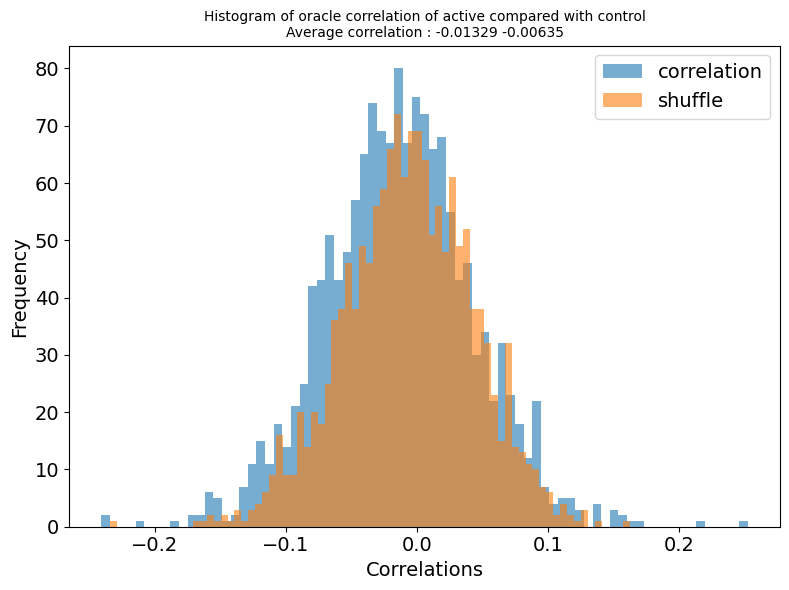

In [16]:
crr = corr(X, oracle, dim=(0,1))
shuffle_corr = corr(shuffle_X, shuffle_oracle, dim=(0,1))
plot_histogram(crr, shuffle_corr, f"Histogram of oracle correlation of active compared with control\n" +\
        f"Average correlation : {crr.mean():.5f} {shuffle_corr.mean():.5f}")

In [17]:
response.shape

(96, 8, 1505)

In [18]:
rng = np.random.default_rng()
X_shuffled = rng.permuted(X, axis=1)
mu_shuffled = X_shuffled.mean(axis=1, keepdims=True)
oracle_shuffled = (mu_shuffled * n_trials - X_shuffled)/(n_trials - 1)

In [19]:
X.shape

(96, 8, 1505)

In [20]:
n = X.shape[1]
n

8

In [21]:
corrs = []
shuffle_corrs = []
n = X.shape[1]
for _ in range(10000):
    idx = np.random.permutation(n)
    
    mu1 = X[:, idx[:n//2], :].mean(axis=1)
    mu2 = X[:, idx[n//2:], :].mean(axis=1)
    corrs.append(corr(mu1, mu2, dim=0, eps=0))

    mu1 = shuffle_X[:, idx[:n//2], :].mean(axis=1)
    mu2 = shuffle_X[:, idx[n//2:], :].mean(axis=1)
    shuffle_corrs.append(corr(mu1, mu2, dim=0, eps=0))
    
corrs = np.vstack(corrs)
corrs.shape, corrs.mean(axis=0)
shuffle_corrs = np.vstack(shuffle_corrs)
shuffle_corrs.shape, shuffle_corrs.mean(axis=0)

((10000, 1505),
 array([-0.03973487,  0.02257996, -0.00284636, ...,  0.03072906,
         0.03455217,  0.04993869]))

Average correlation : -0.0021826758072297937


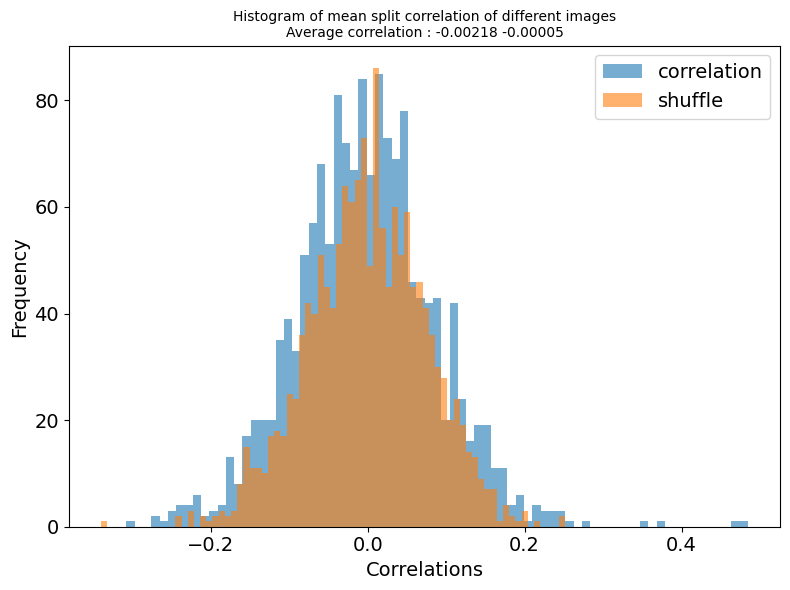

In [22]:
plot_histogram(corrs.mean(axis=0), shuffle_corrs.mean(axis=0), f"Histogram of mean split correlation of different images\n" +\
        f"Average correlation : {corrs.mean():.5f} {shuffle_corrs.mean():.5f}")

In [23]:
corrs = []
shuffle_corrs = []
n = X.shape[1]
for _ in range(3000):
    idx = np.random.permutation(n)
    
    mu1 = X[:, np.random.choice(idx, n//2, replace=False), :].mean(axis=1)
    mu2 = X[:, np.random.choice(idx, n//2, replace=False), :].mean(axis=1)
    corrs.append(corr(mu1, mu2, dim=0, eps=0))

    mu1 = shuffle_X[:, np.random.choice(idx, n//2, replace=False), :].mean(axis=1)
    mu2 = shuffle_X[:, np.random.choice(idx, n//2, replace=False), :].mean(axis=1)
    shuffle_corrs.append(corr(mu1, mu2, dim=0, eps=0))
    
corrs = np.vstack(corrs)
corrs.shape, corrs.mean(axis=0)
shuffle_corrs = np.vstack(shuffle_corrs)
shuffle_corrs.shape, shuffle_corrs.mean(axis=0)

((3000, 1505),
 array([0.48344796, 0.51421279, 0.49981026, ..., 0.51886387, 0.52082922,
        0.5288066 ]))

Average correlation : 0.4934520202566839


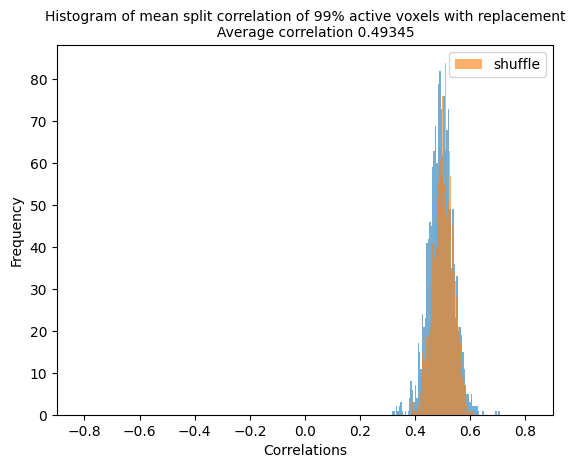

In [24]:
fig, ax = plt.subplots(1,1)
plt.hist(corrs.mean(axis=0), bins=75, alpha=0.6);
plt.hist(shuffle_corrs.mean(axis=0), bins=75, alpha=0.6, label='shuffle');
ax.set_xlabel('Correlations');
ax.set_xlim(-0.9, 0.9)
ax.set_ylabel('Frequency')
ax.set_title(f"Histogram of mean split correlation of 99% active voxels with replacement\n \
    Average correlation {corrs.mean():.5f}", size=10)
ax.legend()
plt.savefig(f'Histogram of mean split correlation of 99% active voxels with replacement'+'.png')
print("Average correlation :", corrs.mean())

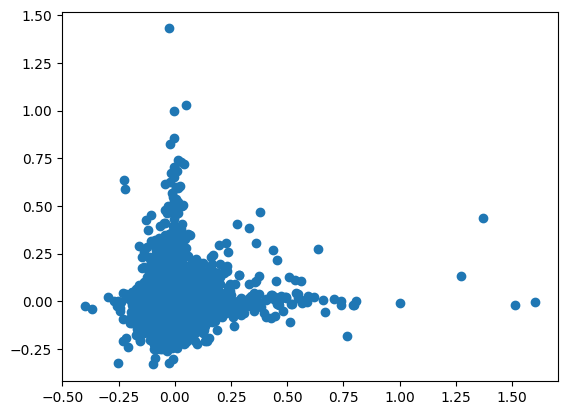

In [25]:
idx = np.random.permutation(n)

mu1 = shuffle_X[:, idx[:n//2],:].mean(axis=1)
mu2 = shuffle_X[:, idx[n//2:],:].mean(axis=1)

plt.scatter(mu1,mu2)

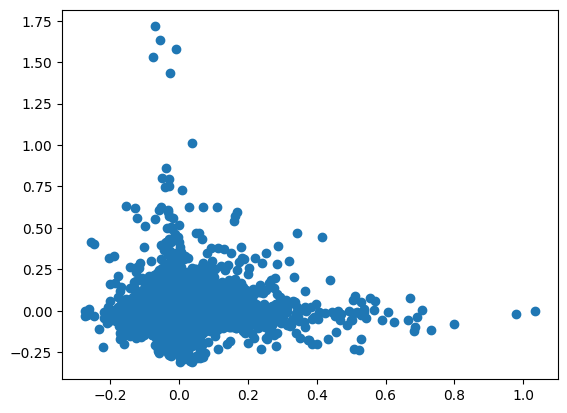

In [26]:
idx = np.random.permutation(n)

mu1 = X[:, idx[:n//2],:].mean(axis=1)
mu2 = X[:, idx[n//2:],:].mean(axis=1)

plt.scatter(mu1,mu2)

In [27]:
neuron = np.random.randint(X.shape[-1])
for i in range(X.shape[1]):
    print(corr(X[:, i, neuron], oracle[:, i, neuron]))

-0.09478549383319879
-0.09031768286721122
0.03327424601103111
0.056568831281781834
-0.03241131000022665
0.0364231450663108
0.11267659382230517
0.03558291923897507


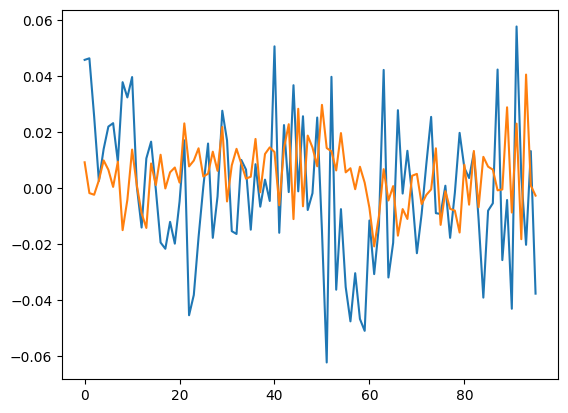

In [28]:
img_indx = 0
plt.plot(X[:, img_indx, 0])
plt.plot(oracle[:, img_indx, 0])

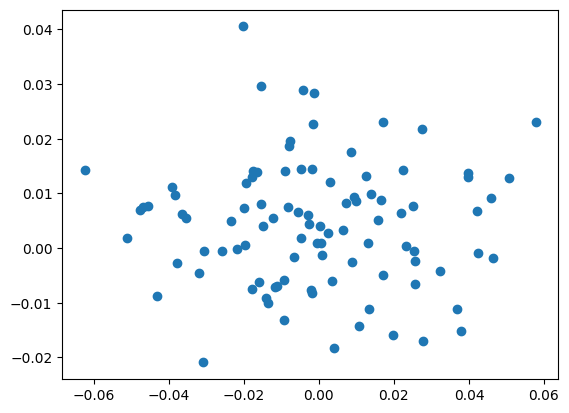

In [29]:
plt.scatter(X[:, img_indx, 0], oracle[:, img_indx, 0])


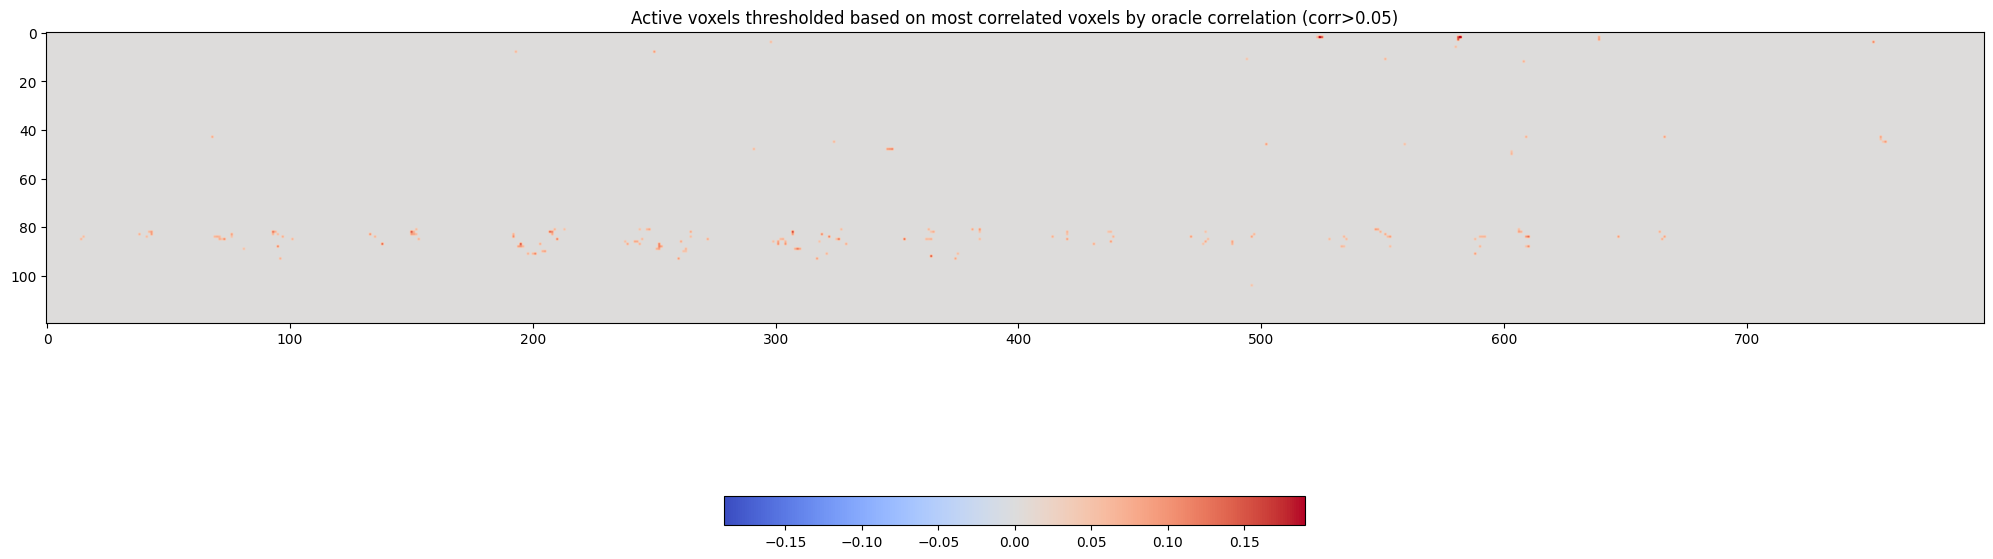

In [30]:
oracle_corr_3d = np.zeros(brain_map_shape)
oracle_corr_3d[active_indices] = crr.flatten().astype(float)#.reshape(brain_map_shape)#
fig, ax = plt.subplots(1, 1, figsize=(25, 15))  


corr_arr = get_stacked_slices(oracle_corr_3d)
# Overlay the correlation values as a heatmap
#cax = ax.imshow(np.where(corr_arr>0, corr_arr, 0), cmap='coolwarm')#, alpha=0.8)
# Add a colorbar
cax = ax.imshow(np.where(corr_arr>0.05, corr_arr, 0), cmap='coolwarm')#, alpha=0.8)
cbar = fig.colorbar(cax, ax=ax, orientation='horizontal', shrink=0.3)
#cbar.set_label('Correlation')
cax.set_clim(-0.19, 0.19)

# Add title and show the plot
ax.set_title(f'Active voxels thresholded based on most correlated voxels by oracle correlation (corr>0.05)')
# cax.set_clim(-0.4, 0.4)
plt.show()

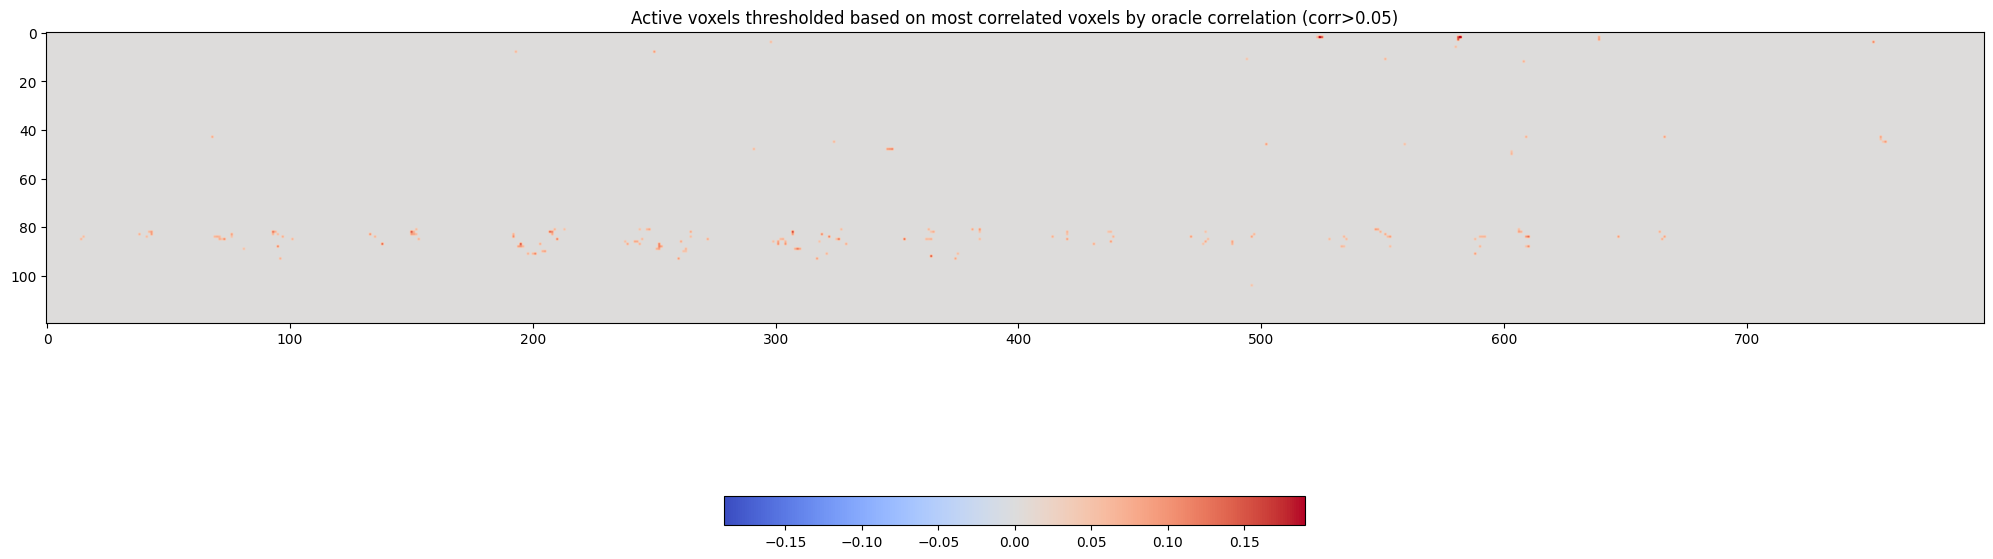

In [31]:
oracle_corr_3d = np.zeros(brain_map_shape)
shuffled_corr = corr(X_shuffled, oracle_shuffled, dim=(0,1))
oracle_corr_3d[active_indices] = shuffled_corr.flatten().astype(float)#.reshape(brain_map_shape)#
fig, ax = plt.subplots(1, 1, figsize=(25, 15))  


corr_arr = get_stacked_slices(oracle_corr_3d)
# Overlay the correlation values as a heatmap
#cax = ax.imshow(np.where(corr_arr>0, corr_arr, 0), cmap='coolwarm')#, alpha=0.8)
# Add a colorbar
cax = ax.imshow(np.where(corr_arr>0.05, corr_arr, 0), cmap='coolwarm')#, alpha=0.8)
cbar = fig.colorbar(cax, ax=ax, orientation='horizontal', shrink=0.3)
#cbar.set_label('Correlation')
cax.set_clim(-0.19, 0.19)

# Add title and show the plot
ax.set_title(f'Active voxels thresholded based on most correlated voxels by oracle correlation (corr>0.05)')
# cax.set_clim(-0.4, 0.4)
plt.show()